# **White-Box Models**

# 1. Upload your files. The relevant files are: Survey, feature_dict and known_kk

In [ ]:
from google.colab import files

uploaded1 = files.upload()
uploaded1 = files.upload()


Saving feature_dict.json to feature_dict.json
Saving known_kk.json to known_kk.json


Saving 230807_Survey.xlsx to 230807_Survey.xlsx


# 2. Install the Libraries

In [ ]:
!pip install transformers torch --quiet
!pip install rapidfuzz
!pip install decision-tree-id3
!apt-get install -y graphviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 59.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 39.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 9.9 MB/s eta 0:00:00
  Cre

3. Import the libraries

In [ ]:
import os
import json
import numpy as np
import pandas as pd
from rapidfuzz import process
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# 4. Inspect the Class Distribution

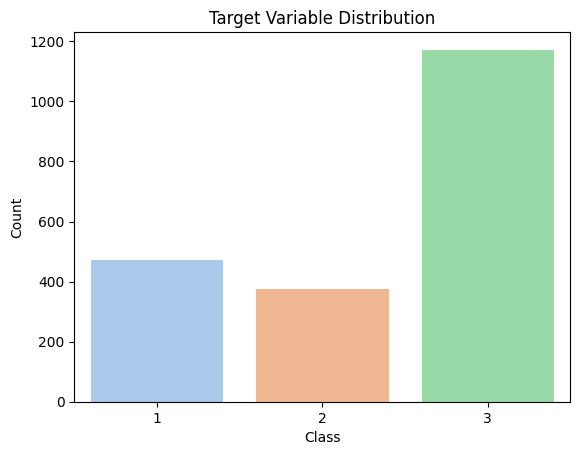

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x=y, palette="pastel")

plt.title('Target Variable Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()
plt.savefig('target_distribution.png', dpi=300, bbox_inches='tight')
files.download('target_distribution.png')

In [ ]:
# For numerical features
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
print("Descriptive statistics for numerical features:")
print(X_train[num_cols].describe().T[['mean', 'std', 'min', '25%', '50%', '75%', 'max']])

# For categorical features
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
print("\nValue counts for categorical features:")
for col in cat_cols:
    print(f"\n{col} value counts:")
    print(X_train[col].value_counts(normalize=True).head(10) * 100)  # Top 10 categories as % frequency


Descriptive statistics for numerical features:
                               mean        std   min   25%   50%   75%   max
geschlecht                 1.521685   0.499684   1.0   1.0   2.0   2.0   2.0
alter                     50.032838  16.665582  18.0  36.0  51.0  65.0  88.0
altersgruppen              4.009913   1.645570   1.0   3.0   4.0   6.0   6.0
region                     7.487608   4.617902   1.0   2.0   9.0  10.0  16.0
kategorie_nutzung          1.000000   0.000000   1.0   1.0   1.0   1.0   1.0
...                             ...        ...   ...   ...   ...   ...   ...
vivida_bkk                 0.002478   0.049736   0.0   0.0   0.0   0.0   1.0
wmf_betriebskrankenkasse   0.000000   0.000000   0.0   0.0   0.0   0.0   0.0
andere_krankenkasse        0.022924   0.149709   0.0   0.0   0.0   0.0   1.0
geraet_select              2.823420   9.369215   1.0   1.0   1.0   3.0  99.0
entry_link_select          1.000000   0.000000   1.0   1.0   1.0   1.0   1.0

[264 rows x 7 columns]

Valu

# 5. Preprocess the training data

In [ ]:
# Load data
df_train = pd.read_excel('230807_Survey.xlsx', sheet_name='Result')

# Define target and features
X = df_train.drop(['Q18'], axis=1)
y = df_train['Q18'].astype(int)  # ensure integer dtype for target
y
# Drop columns with >50% NaN values
nan_threshold_cols = X.columns[(X.isnull().sum() / len(X)) > 0.5]
X = X.drop(columns=nan_threshold_cols)

# Normalize specific text columns (lowercase and strip)
for col in ['Q7.1.1', 'Q7.1.2', 'Q7.1.3']:
    X[col] = X[col].str.lower().str.strip()

# Fill NaNs with specified defaults
X['Q7.1.2'] = X['Q7.1.2'].fillna('keine Angabe')
X['Q7.1.3'] = X['Q7.1.3'].fillna('keine Angabe')
for col in ['Q13', 'Q55.12', 'Q59', 'Q75', 'Q99', 'Q103', 'M1']:
    if col in X.columns:
        X[col] = X[col].fillna(99)

# Load known Krankenkassen for fuzzy matching
with open("known_kk.json", encoding="utf-8") as f:
    known_kassen = json.load(f)

# Mapping function: fuzzy match to known Krankenkassen
def match_kasse(text):
    text = str(text).lower()
    if "techniker" in text:
        return "tk"
    if "dak gesundheit" in text:
        return "dak"
    if "a0k" in text or "aok" in text:
        return "aok"
    result = process.extractOne(text, known_kassen, score_cutoff=70)
    return result[0] if result else text

# Apply fuzzy matching to columns
for col in ['Q7.1.1', 'Q7.1.2', 'Q7.1.3']:
    X[col] = X[col].apply(match_kasse).astype('category')

# Drop unwanted columns if present
drop_cols = ['Participant', 'Weight', 'State', 'Begin', 'End', 'Duration',
             'User Agent', 'pid', 'Source', 'Locale', 'Project ID', 'Phase']
X = X.drop(columns=[c for c in drop_cols if c in X.columns])

# Sentiment Analysis on Q44 column using transformers
model_name = "oliverguhr/german-sentiment-bert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

texts = X['Q44'].fillna('').astype(str).tolist()
results = sentiment_pipeline(texts, truncation=True)
X['Q44'] = pd.Categorical([r['label'].lower() for r in results])

# Rename features using feature_dict.json
with open('feature_dict.json', 'r', encoding='utf-8') as f:
    feature_dict = json.load(f)

X = X.rename(columns=feature_dict)

# Drop specific columns if present
for col in ['zeitpunkt_wechselueberlegung', 'info_quelle_dummy', 'detailgrund_wechsel_dummy', 'zusatzbeitrag_preisaenderung_2', 'hauptgrund_wechsel_textdummy', 'barriere_keine_kasse_ueberzeugt',
            'nutzung_gkv_dummy', 'weiterempfehlungswahrscheinlichkeit_dummy']:
    if col in X.columns:
        X = X.drop(columns=[col])

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Encode categorical columns as integers
def encode_categories(train_df, test_df):
    for col in train_df.select_dtypes(include=['object', 'category']).columns:
        train_df[col] = train_df[col].astype('category')
        # Save categories order
        categories = train_df[col].cat.categories
        test_df[col] = pd.Categorical(test_df[col], categories=categories)
        train_df[col] = train_df[col].cat.codes
        test_df[col] = test_df[col].cat.codes.fillna(-1).astype(int)  # fill unseen as -1
    return train_df, test_df


X_train_encoded, X_test_encoded = encode_categories(X_train.copy(), X_test.copy())

# Ensure integer type for model compatibility
y_train = y_train.astype(np.int64)
y_test = y_test.astype(np.int64)
X_train_encoded = X_train_encoded.astype(np.int64)
X_test_encoded = X_test_encoded.astype(np.int64)

# Now you can continue with model training, evaluation, etc.


Device set to use cpu


# 6. Group rare categories (those are outliers)

In [ ]:
def group_rare_categories(df, column_name, threshold=0, other_label='other'):
    counts = df[column_name].value_counts()
    rare_cats = counts[counts < threshold].index.tolist()
    if rare_cats:
        print(f"Column '{column_name}': Grouping rare categories {rare_cats} into '{other_label}'")
    else:
        print(f"Column '{column_name}': No categories grouped")
    df[column_name] = df[column_name].apply(lambda x: other_label if x in rare_cats else x)
    return df


# Step 2: Identify categorical columns (object or category dtype)
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Step 3: Apply grouping to train and test sets
for col in categorical_cols:
    X_train = group_rare_categories(X_train, col, threshold=10)
    X_test = group_rare_categories(X_test, col, threshold=10)

# Step 4: Then encode categories as integers (your existing encode_categories function)
X_train_encoded, X_test_encoded = encode_categories(X_train.copy(), X_test.copy())


Column 'ungestuetzte_bekanntheit_1': Grouping rare categories ['sbk', 'bkk vbu', 'heimat krankenkasse', 'audi bkk', 'big direkt gesund', 'mhplus betriebskrankenkasse', 'ikk südwest', 'bahn bkk', 'viactiv krankenkasse', 'pronova bkk', 'mobil krankenkasse', 'bkk firmus', 'dak gesundheit', 'keine angabe', 'bkk linde', 'securvita bkk', 'ikk gesund plus', 'skd bkk', 'axa', 'aok badenwürttemberg', 'amazon', 'allianz se', 'svlfg', 'gkv', 'bkk pfaff', 'bkk euregio', 'landwirtschaftliche krankenkasse', 'signal', 'technicker', 'ykd', 'dsy', 'drk', 'diverse', 'hlk', 'buk mobil oil', 'devk', 'dfhtf', 'bkk miele', 'bkk pfalz', 'bkk scheufelen', 'bkk vdn', 'novitas bkk', 'puma', 'manulife', 'picc', 'aok niedersachsen', 'forget', 'gek', 'dkv', 'bkk verbundplus', 'lebensversicherung.', 'manu', 'karl mayer bkk', 'kkh kaufmännische krankenkasse', 'unfallversicherung', 'vivida bkk', 'ögk', 'аок'] into 'other'
Column 'ungestuetzte_bekanntheit_1': Grouping rare categories ['hkk', 'kkh', 'debeka bkk', 'kein

In [ ]:
for col in ['ungestuetzte_bekanntheit_1', 'ungestuetzte_bekanntheit_2', 'ungestuetzte_bekanntheit_3']:
    unique_vals = X_train[col].nunique()
    counts = X_train[col].value_counts()
    print(f"Column {col} has {unique_vals} unique categories.")
    print("Top categories:")
    print(counts.head(10))  # show top 10 categories and their counts
    print("\n")


Column ungestuetzte_bekanntheit_1 has 12 unique categories.
Top categories:
ungestuetzte_bekanntheit_1
aok            737
tk             230
barmer         146
dak            136
other          105
bkk             85
ikk             83
hkk             28
kkh             22
knappschaft     16
Name: count, dtype: int64


Column ungestuetzte_bekanntheit_2 has 12 unique categories.
Top categories:
ungestuetzte_bekanntheit_2
aok             427
barmer          320
keine angabe    259
dak             163
tk              129
bkk              92
other            82
ikk              79
kkh              21
debeka bkk       16
Name: count, dtype: int64


Column ungestuetzte_bekanntheit_3 has 13 unique categories.
Top categories:
ungestuetzte_bekanntheit_3
keine angabe    551
barmer          266
tk              198
aok             133
dak             105
other           100
ikk             100
bkk              77
kkh              26
knappschaft      19
Name: count, dtype: int64




# 7. Use different classification models

# Logistic Regression

In [ ]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(class_weight='balanced')

model.fit(X_train_encoded, y_train)

y_pred = model.predict(X_test_encoded)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.46      0.66      0.54        94
           2       0.44      0.51      0.47        75
           3       0.84      0.66      0.74       235

    accuracy                           0.63       404
   macro avg       0.58      0.61      0.58       404
weighted avg       0.68      0.63      0.64       404



In [ ]:
import numpy as np
import pandas as pd

# Assuming X_train_encoded is a DataFrame or you have feature names list
feature_names = X_train_encoded.columns if hasattr(X_train_encoded, 'columns') else [f'feature_{i}' for i in range(X_train_encoded.shape[1])]

# Get coefficients for each class
coefs = model.coef_

for class_index, class_coef in enumerate(coefs):
    print(f"\nTop features for class {model.classes_[class_index]}:")

    # Sort features by absolute value of coefficients (importance)
    sorted_indices = np.argsort(np.abs(class_coef))[::-1]

    for i in sorted_indices[:10]:  # top 10 features
        print(f"  {feature_names[i]}: coefficient={class_coef[i]:.4f}")



Top features for class 1:
  barriere_keine_bedenken: coefficient=0.2929
  zusatzbeitrag_erhoehung_aktuell: coefficient=0.2378
  zusatzbeitrag_arbeitgeber: coefficient=0.2236
  barriere_verbundenheit_alt: coefficient=-0.2189
  zusatzbeitrag_preisaenderung_1: coefficient=0.2170
  freunde_familie: coefficient=-0.2160
  schlechte_erfahrungen: coefficient=-0.1899
  rankings_tests: coefficient=-0.1776
  barmer: coefficient=-0.1627
  migrationshintergrund_select: coefficient=-0.1558

Top features for class 2:
  schlechte_erfahrungen: coefficient=-0.3172
  webseiten_krankenkassen: coefficient=0.2364
  rankings_tests: coefficient=0.2329
  freunde_familie: coefficient=0.2299
  zusatzbeitrag_arbeitgeber: coefficient=-0.1883
  zusatzbeitrag_preisaenderung_1: coefficient=0.1800
  barriere_keine_bedenken: coefficient=-0.1637
  exzellente_beratung_zu_gesundheitsthemen: coefficient=-0.1542
  barriere_schlechtere_leistungen: coefficient=0.1498
  keine_zusatzversicherung: coefficient=0.1458

Top featur

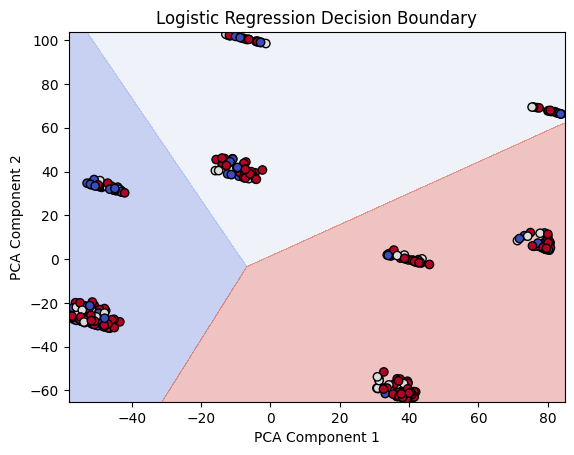

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# For visualization, reduce to 2D with PCA or select 2 features
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_train_2d = pca.fit_transform(X_train_encoded)
X_test_2d = pca.transform(X_test_encoded)

model.fit(X_train_2d, y_train)

# Create mesh grid
x_min, x_max = X_test_2d[:, 0].min() - 1, X_test_2d[:, 0].max() + 1
y_min, y_max = X_test_2d[:, 1].min() - 1, X_test_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=y_test, edgecolor='k', cmap='coolwarm')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Logistic Regression Decision Boundary')
plt.show()


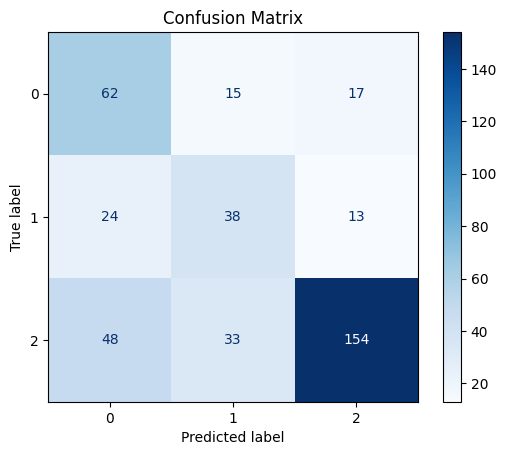

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


# Linear Discriminant Analysis

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.utils.class_weight import compute_sample_weight

model = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
model.fit(X_train_encoded, y_train)

y_pred = model.predict(X_test_encoded)
print(classification_report(y_test, y_pred))



              precision    recall  f1-score   support

           1       0.54      0.59      0.56        94
           2       0.58      0.44      0.50        75
           3       0.79      0.82      0.80       235

    accuracy                           0.70       404
   macro avg       0.64      0.62      0.62       404
weighted avg       0.69      0.70      0.69       404



In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_encoded, y_train)

model = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
model.fit(X_resampled, y_resampled)


LinearDiscriminantAnalysis(shrinkage='auto', solver='lsqr')

In [ ]:
import numpy as np

feature_names = X_train_encoded.columns if hasattr(X_train_encoded, 'columns') else [f'feature_{i}' for i in range(X_train_encoded.shape[1])]

# model.coef_ shape: (n_classes-1, n_features)
coefs = model.coef_

# Sum absolute coefficients over discriminants to get overall importance
overall_importance = np.sum(np.abs(coefs), axis=0)

# Sort features by overall importance
sorted_indices = np.argsort(overall_importance)[::-1]

print("Top 10 overall important features in LDA:")
for i in sorted_indices[:10]:
    print(f"  {feature_names[i]}: importance={overall_importance[i]:.4f}")


Top 10 overall important features in LDA:
  gestuetzte_bekanntheit_AOK: importance=85.8817
  vorerkrankung_parkinson_select: importance=63.5254
  bkk_vbu: importance=40.6929
  migrationshintergrund_select: importance=34.4340
  bkk_scheufelen: importance=29.2345
  chronische_erkrankung_select: importance=26.2143
  vorerkrankung_alzheimer_select: importance=23.6545
  wahlfreiheit_kasse: importance=23.5686
  andere_quellen: importance=23.1885
  mobil_krankenkasse: importance=21.0819


In [ ]:
import numpy as np
import pandas as pd

# Feature names
feature_names = X_train_encoded.columns if hasattr(X_train_encoded, 'columns') else [f'feature_{i}' for i in range(X_train_encoded.shape[1])]

# Get LDA components (n_components = n_classes - 1)
lda_components = model.coef_

# Loop through each component and print top features
for axis, comp in enumerate(lda_components):
    print(f"\nTop features for LDA component {axis + 1}:")

    # Sort by absolute value of coefficients
    sorted_idx = np.argsort(np.abs(comp))[::-1]

    for i in sorted_idx[:10]:  # Top 10
        print(f"  {feature_names[i]}: coefficient={comp[i]:.4f}")



Top features for LDA component 1:
  gestuetzte_bekanntheit_AOK: coefficient=44.3432
  migrationshintergrund_select: coefficient=17.0547
  vorerkrankung_parkinson_select: coefficient=-15.2553
  chronische_erkrankung_select: coefficient=13.2046
  bkk_gildemeister_seidensticker: coefficient=12.9337
  dmp_keine_angabe_select: coefficient=12.0071
  ikk_gesund_plus: coefficient=10.8927
  vorerkrankung_alzheimer_select: coefficient=10.6099
  ikk_suedwest: coefficient=8.7481
  geschlecht: coefficient=8.3029

Top features for LDA component 2:
  gestuetzte_bekanntheit_AOK: coefficient=46.0912
  migrationshintergrund_select: coefficient=17.6971
  bkk_gildemeister_seidensticker: coefficient=13.5321
  vorerkrankung_parkinson_select: coefficient=-13.5045
  chronische_erkrankung_select: coefficient=13.2441
  dmp_keine_angabe_select: coefficient=12.2676
  vorerkrankung_alzheimer_select: coefficient=10.8452
  ikk_gesund_plus: coefficient=10.0187
  bkk_vbu: coefficient=-9.8922
  ikk_suedwest: coefficie

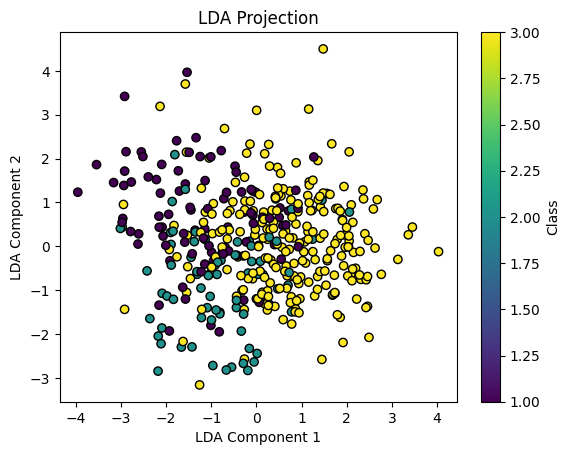

In [ ]:
import matplotlib.pyplot as plt

# Transform test data onto LDA components
X_lda = model.transform(X_test_encoded)

# If LDA returns 1 component, plot it on x-axis; if 2, use x and y
if X_lda.shape[1] == 1:
    plt.scatter(X_lda, y_test, c=y_test, cmap='viridis', edgecolor='k')
    plt.xlabel('LDA Component 1')
    plt.title('LDA Projection')
else:
    plt.scatter(X_lda[:, 0], X_lda[:, 1], c=y_test, cmap='viridis', edgecolor='k')
    plt.xlabel('LDA Component 1')
    plt.ylabel('LDA Component 2')
    plt.title('LDA Projection')

plt.colorbar(label='Class')
plt.show()


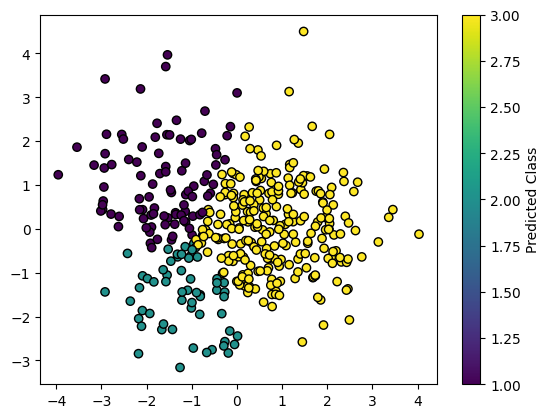

In [ ]:
plt.scatter(X_lda[:, 0], X_lda[:, 1], c=y_pred, cmap='viridis', edgecolor='k')
plt.colorbar(label='Predicted Class')


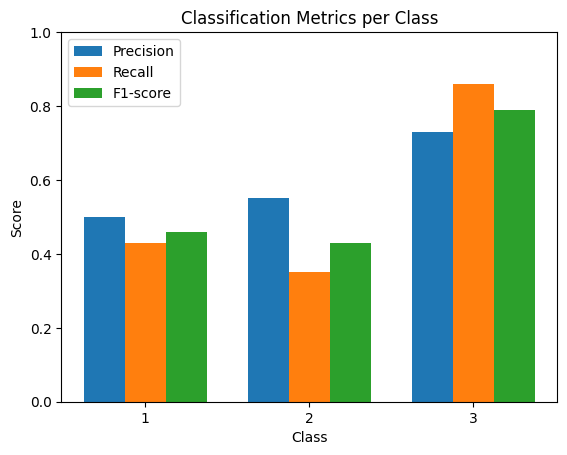

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

classes = ['1', '2', '3']
precision = [0.50, 0.55, 0.73]
recall = [0.43, 0.35, 0.86]
f1 = [0.46, 0.43, 0.79]

x = np.arange(len(classes))
width = 0.25

fig, ax = plt.subplots()
ax.bar(x - width, precision, width, label='Precision')
ax.bar(x, recall, width, label='Recall')
ax.bar(x + width, f1, width, label='F1-score')

ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.set_xlabel('Class')
ax.set_ylabel('Score')
ax.set_title('Classification Metrics per Class')
ax.legend()

plt.ylim(0, 1)
plt.show()


# Decision Trees

In [ ]:
# Decision Trees

from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth=3, random_state=42)  # max_depth optional
tree.fit(X_train_encoded, y_train)

y_pred = tree.predict(X_test_encoded)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.48      0.56      0.52        94
           2       0.69      0.12      0.20        75
           3       0.73      0.87      0.79       235

    accuracy                           0.66       404
   macro avg       0.63      0.52      0.51       404
weighted avg       0.66      0.66      0.62       404



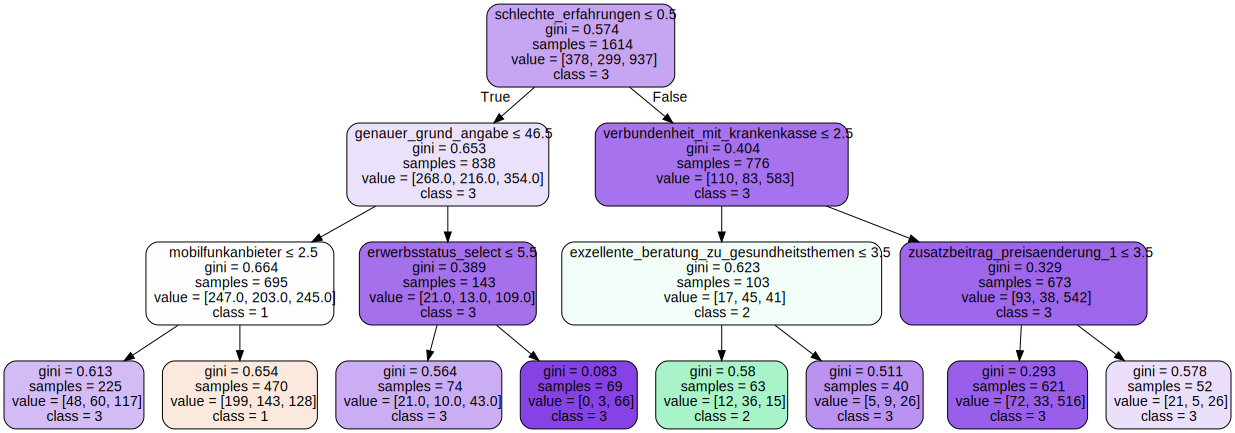

In [ ]:
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz
from sklearn import tree as sk_tree

# Create DOT data
dot_data = sk_tree.export_graphviz(
    tree,
    out_file=None,
    feature_names=X_train.columns,  # if DataFrame
    class_names=[str(cls) for cls in tree.classes_],
    filled=True,
    rounded=True,
    special_characters=True
)

# Display with graphviz
graph = graphviz.Source(dot_data)
graph.render("decision_tree")  # saves as decision_tree.pdf
graph  # displays in notebook


In [ ]:
from google.colab import files
files.download("decision_tree.pdf")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
feature_importances = pd.Series(tree.feature_importances_, index=X_train.columns)
feature_importances.sort_values(ascending=False).head(10)


,0
schlechte_erfahrungen,0.399027
genauer_grund_angabe,0.181927
verbundenheit_mit_krankenkasse,0.169405
mobilfunkanbieter,0.099059
zusatzbeitrag_preisaenderung_1,0.056773
erwerbsstatus_select,0.050000
exzellente_beratung_zu_gesundheitsthemen,0.043809
hkk,0.000000
sbk,0.000000
hek_hanseatische_krankenkasse,0.000000


In [ ]:
import sys
import types
import numpy as np

# Create a dummy six module if missing in sklearn.externals
import six  # install if missing: !pip install six
import sklearn

# Add six to sklearn.externals dynamically
sys.modules['sklearn.externals.six'] = six

# Add np.float back as an alias for float (temporary patch)
if not hasattr(np, 'float'):
    np.float = float



In [ ]:
from id3 import Id3Estimator, export_graphviz
from sklearn.metrics import classification_report

# Train the model
estimator = Id3Estimator()
estimator.fit(X_train_encoded, y_train)

# Evaluate
y_pred = estimator.predict(X_test_encoded)
print(classification_report(y_test, y_pred))

# Export to .dot
export_graphviz(estimator.tree_, 'tree.dot', feature_names=X_train.columns)


# Convert to PDF
!dot -Tpdf tree.dot -o tree.pdf


              precision    recall  f1-score   support

           1       0.43      0.46      0.44        94
           2       0.21      0.19      0.20        75
           3       0.72      0.73      0.72       235

    accuracy                           0.56       404
   macro avg       0.45      0.46      0.45       404
weighted avg       0.56      0.56      0.56       404

